# 기본적인 오토인코더 구현 실습

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2


In [2]:
#@title 데이터 불러오기
train_dataset = datasets.FashionMNIST(
    root = './content/fashion_mnist',
    train = True,
    download=True
)

test_dataset = datasets.FashionMNIST(
    root = './content/fashion_mnist',
    train = False,
    download=True
)

In [3]:
print(len(train_dataset))
print(len(test_dataset))

60000
10000


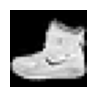

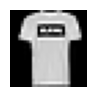

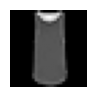

In [4]:
def visualize_data(image, label):
    class_names = range(10)
    plt.figure(figsize=(1,1))
    plt.imshow(image, cmap='gray')
    plt.xlabel(class_names[label])
    plt.axis('off')
    plt.show()

for i in range(3):
    image = train_dataset[i][0]
    label = train_dataset[i][1]
    visualize_data(image, label)

## 기본 전처리 후 데이터 불러오기

In [5]:
transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True)
    ]
)

In [6]:
#@title 데이터 불러오기
train_dataset = datasets.FashionMNIST(
    root = './content/fashion_mnist',
    train = True,
    download=True,
    transform=transforms
)

test_dataset = datasets.FashionMNIST(
    root = './content/fashion_mnist',
    train = False,
    download=True,
    transform=transforms
)

In [7]:
image, label = train_dataset[0]
print(type(image))

<class 'torchvision.tv_tensors._image.Image'>


## 데이터 로더

In [8]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, drop_last=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32)

## 모델 생성 및 학습

In [9]:
class BasicAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y

In [10]:
model = BasicAutoEncoder()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model.to(device)

cuda


BasicAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [12]:
#@title Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, _ in train_dataloader:
        images = images.view(images.size(0), -1).to(device) # batch x 28x28 -> batch x 784 벡터
        outputs = model(images)
        loss = loss_fn(outputs, images)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} loss {total_loss / len(train_dataloader):.4f}")

Epoch 1/10 loss 0.0828
Epoch 2/10 loss 0.0415
Epoch 3/10 loss 0.0304
Epoch 4/10 loss 0.0260
Epoch 5/10 loss 0.0239
Epoch 6/10 loss 0.0226
Epoch 7/10 loss 0.0215
Epoch 8/10 loss 0.0206
Epoch 9/10 loss 0.0198
Epoch 10/10 loss 0.0192


## 모델 평가

In [13]:
model.eval()
with torch.no_grad():
    # images, _ = next(iter(test_dataloader))
    for images, _ in test_dataloader:
        images = images.view(images.size(0), -1).to(device) # batch x 784
        outputs = model(images)                             # batch x 784
        break

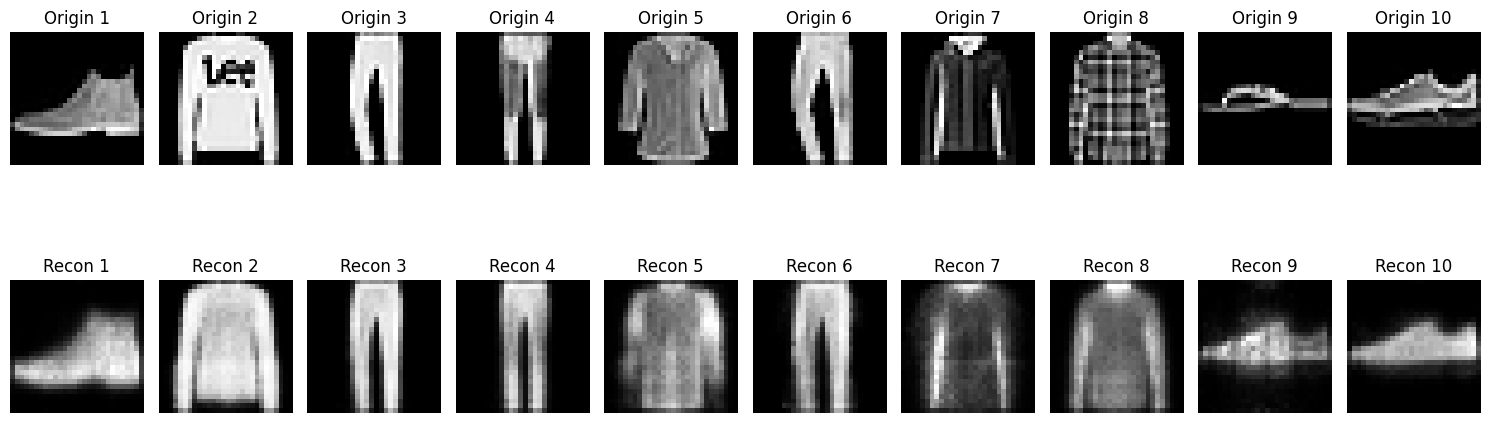

In [14]:
# 이미지 형태로 복원
images = images.view(-1, 28, 28)   # batch x 784 -> # batch x 28 x 28
outputs = outputs.view(-1, 28, 28) # batch x 784 -> # batch x 28 x 28

fig, axes = plt.subplots(2,10, figsize=(15,6))

for i in range(10):
    #원본
    axes[0, i].imshow(images[i].cpu().detach().numpy(), cmap='gray')
    axes[0, i].set_title(f"Origin {i+1}")
    axes[0, i].axis('off')

    #복원
    axes[1, i].imshow(outputs[i].cpu().detach().numpy(), cmap='gray')
    axes[1, i].set_title(f"Recon {i+1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# 차원 축소 시각화

In [15]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2

from mpl_toolkits.mplot3d import Axes3D

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [17]:
transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True)
    ]
)

train_dataset = datasets.MNIST(
    root = './data',
    train = True,
    download=True,
    transform=transforms
)
test_dataset = datasets.MNIST(
    root = './data',
    train = False,
    download=True,
    transform=transforms
)


In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=128)

In [19]:
#@title  모델 정의
class AutoEncoder3D(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # --> latent vector 3차원
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon

    def encode(self, x):
        return self.encoder(x)

In [20]:
model = AutoEncoder3D().to(device)

In [21]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [22]:
#학습 루프

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, _ in train_dataloader:
        images = images.view(images.size(0), -1).to(device)
        outputs = model(images)

        loss = loss_fn(outputs, images)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}  Loss = {total_loss / len(train_dataloader):.4f}")

Epoch 1/10  Loss = 0.1119
Epoch 2/10  Loss = 0.0655
Epoch 3/10  Loss = 0.0594
Epoch 4/10  Loss = 0.0568
Epoch 5/10  Loss = 0.0552
Epoch 6/10  Loss = 0.0536
Epoch 7/10  Loss = 0.0519
Epoch 8/10  Loss = 0.0500
Epoch 9/10  Loss = 0.0489
Epoch 10/10  Loss = 0.0483


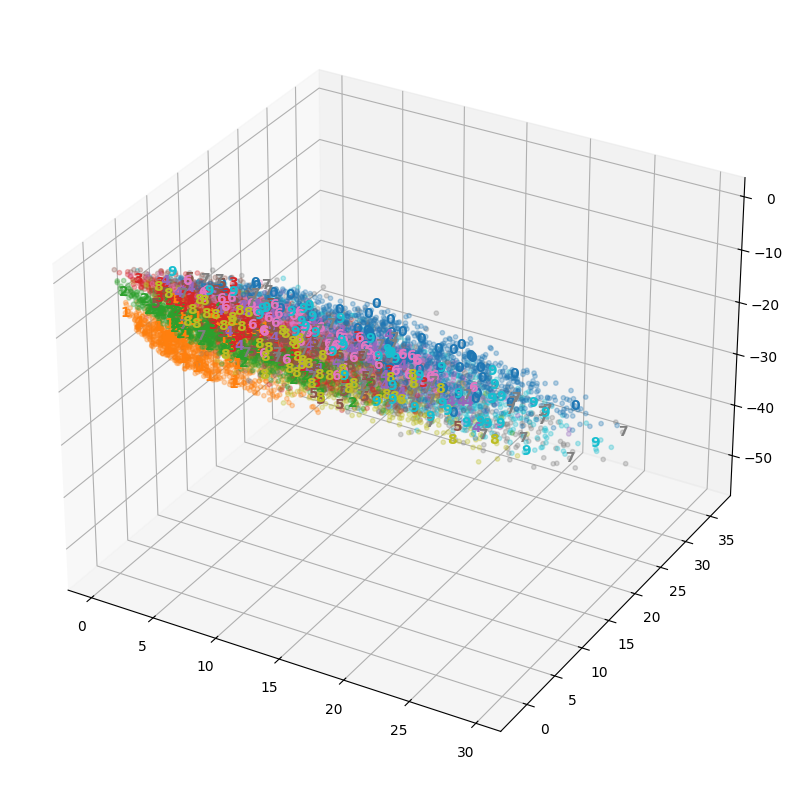

In [23]:
# latent 공간 시각화를 위한 데이터 추출
model.eval()
all_latents = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.view(images.size(0), -1).to(device)

        #latent vector만 추출
        latent = model.encode(images)
        all_latents.append(latent.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_latents = np.concat(all_latents, axis=0)
all_labels = np.concat(all_labels, axis=0)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(all_latents[:,0],all_latents[:,1],all_latents[:,2],
                     c=all_labels, cmap='tab10', s=10, alpha=0.3)

# 각 digit별로 일부 포인트만 선택하여 텍스트 어노테이션 추가
for digit in range(10):
    # 현재 클래스(digit)에 해당하는 인덱스 찾기
    indices = np.where(all_labels == digit)[0]
    # 전체 포인트 중에서 최대 50개를 무작위로 샘플링
    sample_indices = np.random.choice(indices, size=min(50, len(indices)), replace=False)

    for idx in sample_indices:
        x, y, z = all_latents[idx, 0], all_latents[idx, 1], all_latents[idx, 2]
        ax.text(x,y,z,str(digit),
                color=plt.cm.tab10(digit),
                fontsize=10,
                fontweight='bold',
                ha='center', va='center')


In [25]:
import plotly.graph_objects as go
import numpy as np

# 각 숫자(0~9)에 대한 색상 리스트 (Plotly 기본 색상 사용)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
          "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

fig = go.Figure()

for digit in np.unique(all_labels):
    indices = np.where(all_labels == digit)[0]
    sample_indices = np.random.choice(indices, size=min(100, len(indices)), replace=False)

    fig.add_trace(go.Scatter3d(
        x = all_latents[sample_indices, 0],
        y = all_latents[sample_indices, 1],
        z = all_latents[sample_indices, 2],
        mode = 'text',
        text=[str(digit)] * len(sample_indices),
        textposition='middle center',
        textfont=dict(color=colors[int(digit)], size=12),
        name=f"Digit {digit}"
    ))
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed